In [258]:
import importlib

import pytorch3d
from pytorch3d.structures import Pointclouds
from pytorch3d import transforms
from scipy.spatial.transform import Rotation as R
import torch
import numpy as np
import copy
import matplotlib.pyplot as plt
# Setup
if torch.cuda.is_available():
    device = torch.device(0)
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")
device

from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVOrthographicCameras, 
    PointsRasterizationSettings,
    PointsRenderer,
    PulsarPointsRenderer,
    PointsRasterizer,
    AlphaCompositor,
    NormWeightedCompositor


)
from pytorch3d.renderer.mesh.shader import HardPhongShader
color_list = [[84, 107, 45], [178, 0, 0], [135, 206, 234]  ,[239, 196, 15]   ,[216, 112, 214]  ,[255, 127, 79]   ,[0, 127, 127]    ,[237, 58, 130]   ,[196, 237, 0]    ,[0, 0, 127]      ,[137, 53, 15]    ,[112, 127, 142]  ,[178, 127, 209]  ,[255, 216, 178]  ,[127, 127, 0]    ,[53, 68, 79]     ,[183, 75, 107],[70, 72, 107],[180, 123, 95],[137, 66, 70]]
color_list_new = []
for c in color_list:
    color_list_new.append([a/255 for a in c])


0.7264814972877502

In [301]:
import jahn_src.slice_util as slice_util
importlib.reload(slice_util)
from jahn_src.slice_util import combine_obj_files
_dir = '/data/jhahn/data/shape_dataset/data/shape/vase/0/fractured_0'
output_file_name = '../output/comb_rotated.obj'
_pc_list = combine_obj_files(_dir,output_file_name)
#print(_pc_list)

/data/jhahn/data/shape_dataset/data/shape/vase/0/fractured_0/piece_2.obj
torch.Size([8819, 3])
/data/jhahn/data/shape_dataset/data/shape/vase/0/fractured_0/piece_3.obj
torch.Size([3563, 3])
/data/jhahn/data/shape_dataset/data/shape/vase/0/fractured_0/piece_1.obj
torch.Size([10061, 3])


/data/jhahn/data/shape_dataset/data/shape/vase/0/fractured_0/piece_0.obj
torch.Size([6301, 3])


In [277]:



_part_pcs = torch.from_numpy(copy.deepcopy(_pc_list[0]))
print(_part_pcs)

_part_pcs = rotate_pc(_part_pcs)

print(_part_pcs)


tensor([[ 0.4174,  0.7710, -0.0966],
        [ 0.4138,  0.7710, -0.0954],
        [ 0.4161,  0.7753, -0.0943],
        ...,
        [ 0.7829,  0.7977,  0.6831],
        [ 0.7907,  0.8031,  0.6761],
        [ 0.7996,  0.8086,  0.6709]], dtype=torch.float64)
tensor([[ 0.7866,  0.7710,  0.6886],
        [ 0.7903,  0.7710,  0.6874],
        [ 0.7879,  0.7753,  0.6864],
        ...,
        [ 0.4212,  0.7977, -0.0910],
        [ 0.4133,  0.8031, -0.0841],
        [ 0.4045,  0.8086, -0.0789]], dtype=torch.float64)


In [278]:

verts = []
rgbs = []

for part_id, part_pcs in enumerate(_pc_list):
    
    #rot_mat = scipy.spatial.transform.Rotation.random().as_matrix()
    part_pcs =  torch.from_numpy(part_pcs)
    #rot_mat = scipy.spatial.transform.Rotation.from_rotvec(np.pi/2 * np.array([0, 0, 1])).as_matrix()
    #_part = (rot_mat @ _part.T).T

    #part_pcs[:,0] = part_pcs[:,0] - (torch.rand(1).item() - 0.5)
    #part_pcs[:,2] = part_pcs[:,2] -  part_id*0.1

    part_pcs = rotate_pc(part_pcs)

    verts.extend(part_pcs)
    
    rgbs.extend([color_list_new[part_id] for _ in range(len(part_pcs))])

verts = torch.Tensor(np.array(verts)).to(device)
rgbs = torch.Tensor(rgbs).to(device)
point_cloud = Pointclouds(points=[verts], features=[rgbs])

print(torch.min(point_cloud.points_list()[0], axis=0))
print(torch.max(point_cloud.points_list()[0], axis=0))
print(torch.min(point_cloud.features_list()[0], axis=0))
print(torch.max(point_cloud.features_list()[0], axis=0))
#torch.max(point_cloud.points_list()[0])

torch.return_types.min(
values=tensor([ 0.2171,  0.2781, -0.1259], device='cuda:0'),
indices=tensor([11290, 25507, 22119], device='cuda:0'))
torch.return_types.max(
values=tensor([1.0102, 1.2639, 0.7109], device='cuda:0'),
indices=tensor([14420, 10746, 13078], device='cuda:0'))
torch.return_types.min(
values=tensor([0.3294, 0.0000, 0.0000], device='cuda:0'),
indices=tensor([   0, 8819, 8819], device='cuda:0'))
torch.return_types.max(
values=tensor([0.9373, 0.8078, 0.9176], device='cuda:0'),
indices=tensor([22443, 12382, 12382], device='cuda:0'))


In [283]:

'''
    dist: distance of the camera from the object
    elev: angle in degrees or radians. This is the angle between the
        vector from the object to the camera, and the horizontal plane y = 0 (xz-plane).
    azim: angle in degrees or radians. The vector from the object to
        the camera is projected onto a horizontal plane y = 0. azim is the angle between the projected vector and a reference vector at (0, 0, 1) on the reference plane (the horizontal plane).
    dist, elev and azim can be of shape (1), (N).
    degrees: boolean flag to indicate if the elevation and azimuth
        angles are specified in degrees or radians.
    eye: the position of the camera(s) in world coordinates. If eye is not
        None, it will override the camera position derived from dist, elev, azim.
    up: the direction of the x axis in the world coordinate system.
    at: the position of the object(s) in world coordinates. eye, up and at can be of shape (1, 3) or (N, 3).
'''

# Initialize a camera.
#R, T = look_at_view_transform(20, 10, 0)
R, T = look_at_view_transform(dist=1.0, elev=0,azim=45)
#An azimuth is the horizontal angle from a cardinal direction, most commonly north


print(R)
print(T)
#T = torch.from_numpy(np.array([0.5,-0.5,0.5])).unsqueeze(0)
cameras = FoVOrthographicCameras(device=device, max_y=1.5,  min_y=-1.0, R=R, T=T)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. Refer to raster_points.py for explanations of these parameters. 
raster_settings = PointsRasterizationSettings(
    image_size=512, 
    radius = 0.002,
    points_per_pixel = 100
)


# Create a points renderer by compositing points using an alpha compositor (nearer points
# are weighted more heavily). See [1] for an explanation.
rasterizer = PointsRasterizer(cameras=cameras, raster_settings=raster_settings)
renderer = PointsRenderer(
    rasterizer=rasterizer
    ,compositor=AlphaCompositor()
    #,shader=HardPhongShader(device=device, cameras=cameras)
)

tensor([[[-0.7071,  0.0000, -0.7071],
         [ 0.0000,  1.0000,  0.0000],
         [ 0.7071,  0.0000, -0.7071]]])
tensor([[-0., -0., 1.]])


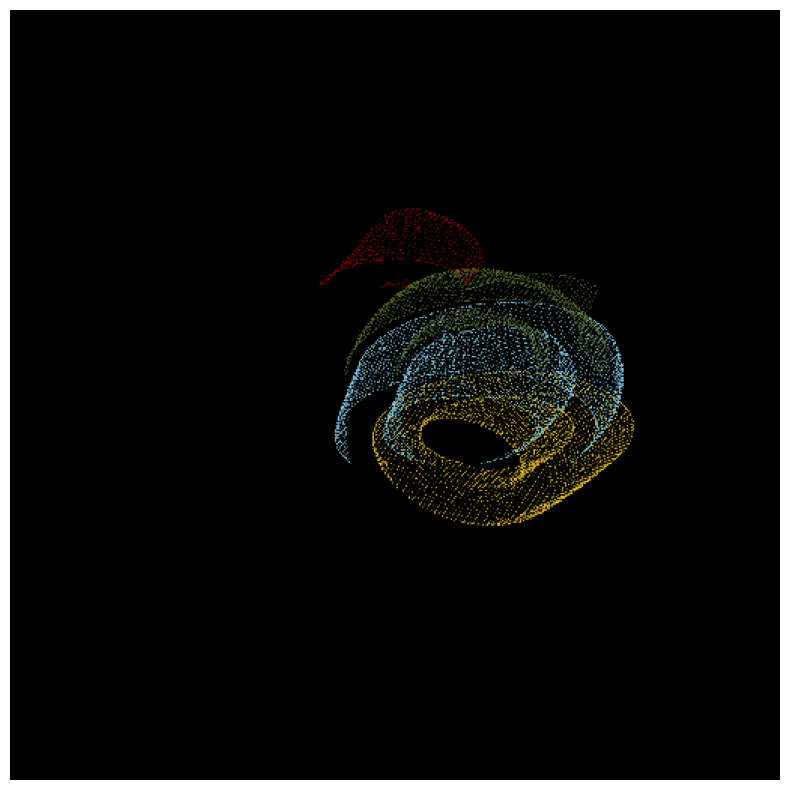

In [282]:
images = renderer(point_cloud)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off");

In [29]:
for part_pcs in _pc_list:
    rot_mat = R.random().as_matrix()
    #print('rot_mat')
    #print(rot_mat)
    part_pcs = (rot_mat @ part_pcs.T).T
    #print('pc')
    #print(pc.shape)
    noise_quat = R.from_matrix(rot_mat.T).as_quat()
    noise_quat = torch.from_numpy(noise_quat)
    part_pcs = torch.from_numpy(part_pcs)
    #print('quat_gt')
    #print(quat_gt)
    # we use scalar-first quaternion
    noise_quat = noise_quat[[3, 0, 1, 2]]
    noise_quat[1] = 0.0
    noise_quat[3] = 0.0
    print(noise_quat)
    print(part_pcs)
    #noise_quat = noise_params[..., 3:]
    #noise_quat = noise_quat / noise_quat.norm(dim=-1, keepdim=True)
    part_pcs = transforms.quaternion_apply(noise_quat, part_pcs)



tensor([-0.0854,  0.0000, -0.5219,  0.0000], dtype=torch.float64)
tensor([[-0.7427, -0.3662, -0.3038],
        [-0.7396, -0.3662, -0.3060],
        [-0.7429, -0.3697, -0.3074],
        ...,
        [-0.6374, -1.1431,  0.0531],
        [-0.6491, -1.1416,  0.0531],
        [-0.6607, -1.1419,  0.0541]], dtype=torch.float64)
tensor([-0.0989,  0.0000,  0.8128,  0.0000], dtype=torch.float64)
tensor([[ 0.9968,  0.6146, -0.1127],
        [ 0.9914,  0.6164, -0.1152],
        [ 0.9961,  0.6104, -0.1177],
        ...,
        [ 1.0172,  0.7984, -0.5372],
        [ 1.0186,  0.8099, -0.5347],
        [ 1.0200,  0.8198, -0.5284]], dtype=torch.float64)
tensor([ 0.1705,  0.0000, -0.6290,  0.0000], dtype=torch.float64)
tensor([[-0.1495, -0.0723, -0.7508],
        [-0.1550, -0.0665, -0.7599],
        [-0.1601, -0.0678, -0.7565],
        ...,
        [-0.3772, -0.9073, -0.8405],
        [-0.3722, -0.9081, -0.8384],
        [-0.3799, -0.9067, -0.8417]], dtype=torch.float64)
tensor([0.2313, 0.0000, 0.8447,